<a href="https://colab.research.google.com/github/GuiCoelhoDev/CoronaryDisease_Analysis/blob/main/Projeto1_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Google Drive Auth

In [ ]:
#@title  Imports
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix



from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn import tree # for decision tree models
from sklearn.metrics import plot_confusion_matrix, roc_curve, roc_auc_score

import plotly.express as px  # for data visualization
import plotly.graph_objects as go # for data visualization
import graphviz # for plotting decision tree graphs

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold




In [ ]:
#@title  Google Drive Auth

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [ ]:
#@title Load dataset

link = 'https://drive.google.com/file/d/1QFfy98RZcXYdx2U8SePO1TcYwZ236aPT/view?usp=sharing'

fluff, parsed = link.split('/d/')
id, fluff = parsed.split('/')

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('SA_heart.csv')
df = pd.read_csv('SA_heart.csv')
df
# Dataset is now stored in a Pandas Dataframe

,id,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1
...,...,...,...,...,...,...,...,...,...,...,...
457,459,214,0.40,5.98,31.72,Absent,64,28.45,0.00,58,0
458,460,182,4.20,4.41,32.10,Absent,52,28.61,18.72,52,1
459,461,108,3.00,1.59,15.23,Absent,40,20.09,26.64,55,0
460,462,118,5.40,11.61,30.79,Absent,64,27.35,23.97,40,0


In [ ]:
#@title Pre Processing

dataset=df[pd.isnull(df['chd'])==False]
dataset=dataset.fillna(dataset.mean())
dataset['famhist'] = dataset['famhist'].apply(lambda x: 1 if x=='Present' else 0)
dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.


,id,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1
...,...,...,...,...,...,...,...,...,...,...,...
457,459,214,0.40,5.98,31.72,0,64,28.45,0.00,58,0
458,460,182,4.20,4.41,32.10,0,52,28.61,18.72,52,1
459,461,108,3.00,1.59,15.23,0,40,20.09,26.64,55,0
460,462,118,5.40,11.61,30.79,0,64,27.35,23.97,40,0


# Questão 1

### Summarize Data (Análise estatística dos dados)


Utilizando o método shape, foi possível perceber que temos 462 amostras com 11 colunas. Sendo 9 colunas sendo variáveis produtoras, uma para o identificador e outra para a classificação da amostra.

Posteriormente, foi utilizado o método sample. Foi escolhido ele em vez do head() ou tail() para poder pegar amostras aleatoriamente no dataset. Ao ver 20 amostras aleatórias, acredita-se que pessoas mais velhas tem mais chance de ter chd do que mais novos. Porém, não da pra ter certeza utilizando apenas esse método. É apenas uma hipótese

Observando os resultados do describe(), verifiquei que a maior parte das amostras são rotuladas como SEM chd pois a média desse valor está em 0.346320.
- Total: 462
- 65% (302)- 0 (hasnt CHD)
- 35% (160) - 1 (has CHD)

sbp -> systolic blood pressure

Perguntas a serem respondidas:

1.   Dado todos os testados positivos, qual a proporção de idade, alcohol, tobacco, etc deles?




In [ ]:
#@title Análises gerais
print("\nShape")
print(dataset.shape)
print("\nSamples")
print(dataset.sample(20))
print("\nDescribe")
print(dataset[['obesity','tobacco', 'alcohol','chd','famhist']].describe())
print("\Columns")
print(dataset.columns)




Shape
(462, 11)

Samples
      id  sbp  tobacco   ldl  adiposity  ...  typea  obesity  alcohol  age  chd
390  392  130     0.54  3.63      22.03  ...     69    24.34    12.86   39    1
191  192  128     0.70  4.90      37.42  ...     72    35.94     3.09   49    1
123  124  138     4.50  2.85      30.11  ...     55    24.78    24.89   56    1
196  197  128     0.00  3.09      20.57  ...     54    25.63     0.51   17    0
79    80  108     0.40  5.91      22.92  ...     57    25.72    72.00   39    0
221  222  164     0.50  6.95      39.64  ...     47    41.76     3.81   46    1
1      2  144     0.01  4.41      28.61  ...     55    28.87     2.06   63    1
353  355  134    11.79  4.01      26.57  ...     38    21.79    38.88   61    1
436  438  138     0.00  1.86      18.35  ...     59    25.38     6.51   17    0
278  280  114     0.00  2.63       9.69  ...     45    17.89     0.00   16    0
226  227  112     4.46  7.18      26.25  ...     69    27.29     0.00   32    1
185  186  122 

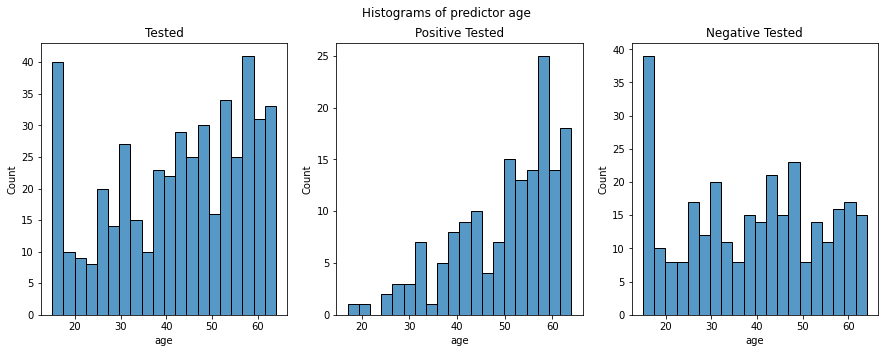

In [ ]:
tested_positive = dataset.query('chd == 1')
tested_negative = dataset.query('chd == 0')

preditor_selecionado = 'age' #@param ['sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'typea', 'obesity', 'alcohol', 'age']

fig, axes = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Histograms of predictor {}'.format(preditor_selecionado))
sns.histplot(ax = axes[0], data=dataset, x=preditor_selecionado, bins=20)
axes[0].set_title("Tested")

sns.histplot(ax = axes[1],data=tested_positive, x=preditor_selecionado, bins=20)
axes[1].set_title("Positive Tested")

sns.histplot(ax = axes[2],data=tested_negative, x=preditor_selecionado, bins=20)
axes[2].set_title("Negative Tested")
plt.show()


Baseado nos histogramas acima pode-se concluir:


1.   Quanto maior a idade, maior a chance de ser testado positivo
2.   alcohol, sbp, e ldl não parecem ser preditores muito úteis para classificação
3.   A variável famhist é mais presente quando o paciente é testado positivamente. Enquanto a variável é mais ausente quando o paciente é testado negativamente.
4.  Incrivelmente, o fator obesidade e alcohol não é um preditor tão impactante quanto a idade, por exemplo.
5.  Inicialmente, achava que quanto maior o alcohol, obesity, tobacco, maior a chance de ser positivo. Porém, ao analisar os histogramas, percebe-se que a lógica é inversa. No caso do tobacco por exemplo, a maior parte se encontra perto do 0. E poucos se encontram perto de 40. Portanto, acredito que quanto menor o valor dessa variável, mais tabaco ela ingeriu. Pois não faz sentido pessoas que usarem mais tabaco terem menos chance de pegar do que quem não usou. Essa lógica se repete para alcohol, 



# Questão 2

## Referências do código utilizado:
https://towardsdatascience.com/cart-classification-and-regression-trees-for-clean-but-powerful-models-cc89e60b7a85
https://machinelearningmastery.com/machine-learning-in-python-step-by-step/
## Observações


1.   Para depth = 3, 'entropy', 'random', acuracia de 0.66666 sem utilizar validação cruzada
2.   Para depth = 4, 'entropy', 'random', acuracia de 0.71 sem utilizar validação cruzada
3. Não era para a validação cruzada ter um resultado melhor do que em?
4. 10 splits foi o que deu melhor resultado de acurácia (68,3%)
5. Com 10% dos dados para teste, o EvaluationTest caiu para 0.59. Antes era 0.66
6. A precisão para casos positivos foi muito baixa (19%) comparada aos casos negativos (80%). Acredito que isso se deve ao fato de 35% da base de dados ser de casos positivos e 65% de negativos. C






In [ ]:

from sklearn.metrics import auc
def fitting(X, y):

    # Create training and testing samples (Changing the test_size impaccts on cv_results)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

    # Set up test harness using 10-fold cross validation

    # Declaring the model, test min_samples and random_state values
    model = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=3, random_state=0)

      # DÚVIDA: Ele vai pegar a divisão que eu já fiz no train_test_split e vai dai dividir de novo? 
      # Qual a diferença do cross_val_score pro model.fit?
      # DÚVIDA: Pq minhas predições com os casos de teste foram tão ruins?

    # Performing the 10-cross validation 

    kfold = StratifiedKFold(n_splits = 10, random_state = 1, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    
    print(cv_results)
    print('%s: %f (%f)' % ("CART", cv_results.mean(), cv_results.std()))
    
    # Training the model using training data
    model = model.fit(X_train, y_train)

    # Plotting the tree
    plt.figure(figsize=(15,7.5))
    tree.plot_tree(model, filled=True,rounded=True,class_names=["NO CHD", "YES CHD"], feature_names=X.columns);

    # Confusion Matrix

    plot_confusion_matrix(model, X_test, y_test, display_labels=["NO CHD", "YES CHD"])

    # AUC ROC

    predictions = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
    
    # print(roc_auc_score(y_test, predict_proba[:,1]))

    # ROC CURVE

    # plt.clf()
    # plt.figure(figsize=(5,5),dpi=100)
    # plt.plot(fpr,tpr)
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('ROC curve')
    # plt.show()

    # AUC ROC Curve

    auc_cart = auc(fpr,tpr)
    plt.figure(figsize=(5,5), dpi=100)
    plt.plot(fpr,tpr,linestyle='-', label='AUC = %0.3f' % auc_cart)
    plt.xlabel('False Positive Rate')
    plt.title("AUC ROC Curve")
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    


    return X_train, X_test, y_train, y_test


                                 


[0.73809524 0.64285714 0.5952381  0.69047619 0.64285714 0.75609756
 0.70731707 0.63414634 0.63414634 0.65853659]
CART: 0.669977 (0.048607)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


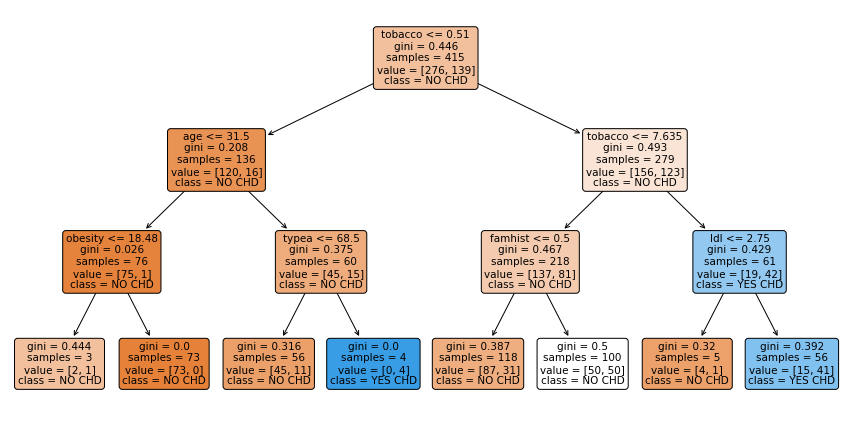

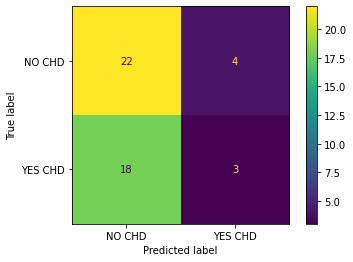

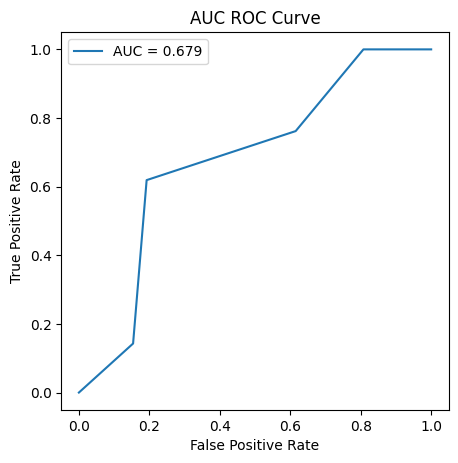

ytest [1 0 1 1 0 1 0 0 0 1 0 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0 0
 1 1 0 1 0 0 0 0 1 0]


In [ ]:
X=dataset[['sbp','famhist','tobacco','ldl','adiposity','typea','obesity','alcohol','age']]
y=dataset['chd'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)



X_train, X_test, y_train, y_test = fitting(X,y)

print('ytest',y_test)







# Conforme aumenta a profundidade da árvore, vai se criando um Overfitting
# O treinamento fica com uma alta acurácia, porém o test não




In [ ]:
dataset[['sbp','tobacco','ldl','adiposity','typea','obesity','alcohol','age']]
X.columns

# ROC AUC https://www.youtube.com/watch?v=TEkvKx2tQHU | https://www.youtube.com/watch?v=4jRBRDbJemM
print("Accuracy", 25/47)
print("PrecisionNEG", 20/26)
print("PrecisionPOS", 5/21)



Accuracy 0.5319148936170213
PrecisionNEG 0.7692307692307693
PrecisionPOS 0.23809523809523808


# Questão 3

CART: 0.672067 (0.073658)


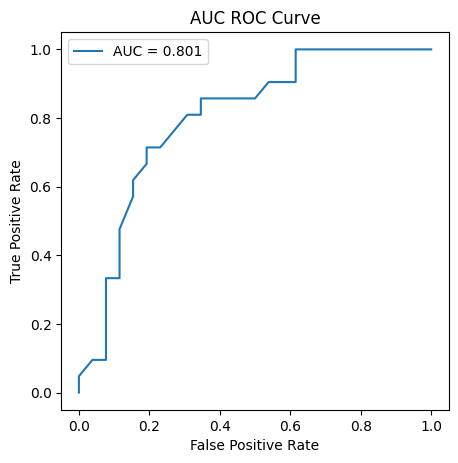

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy 0.6595744680851063
PrecisionNEG 0.7692307692307693
PrecisionPOS 0.5238095238095238


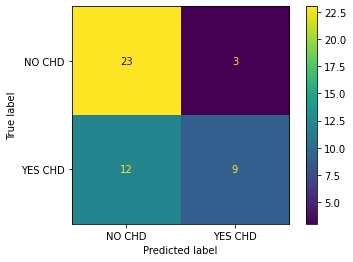

In [ ]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

X=dataset[['sbp','famhist','tobacco','ldl','adiposity','typea','obesity','alcohol','age']]
y=dataset['chd'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

rf_model = RandomForestClassifier(n_estimators=100, max_features=9)

kfold = StratifiedKFold(n_splits = 10, random_state = 1, shuffle=True)
cv_results = cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='accuracy',error_score='raise')
print('%s: %f (%f)' % ("CART", cv_results.mean(), cv_results.std()))

rf_model.fit(X_train, y_train)

predictions = rf_model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test,predictions[:,1])

# AUC ROC Curve
auc_cart = auc(fpr,tpr)
plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr,tpr,linestyle='-', label='AUC = %0.3f' % auc_cart)
plt.xlabel('False Positive Rate')
plt.title("AUC ROC Curve")
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Confusion Matrix

plot_confusion_matrix(rf_model, X_test, y_test, display_labels=["NO CHD", "YES CHD"])

# Accuracy and Precision

print("Accuracy", 31/47)
print("PrecisionNEG", 20/26)
print("PrecisionPOS", 11/21)










# Questão 4

X_train 415
X_test 47
y_train 415
y_test 47
CART: 0.679326 (0.063130)


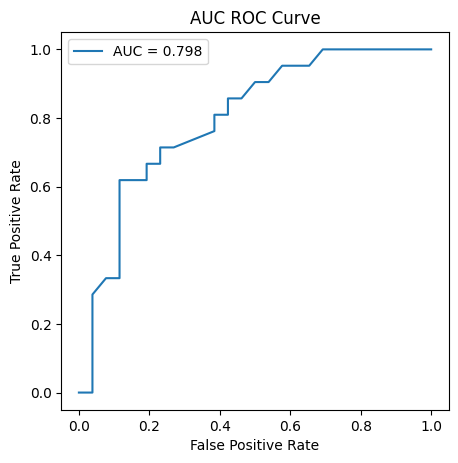

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy 0.723404255319149
PrecisionNEG 0.8846153846153846
PrecisionPOS 0.5238095238095238


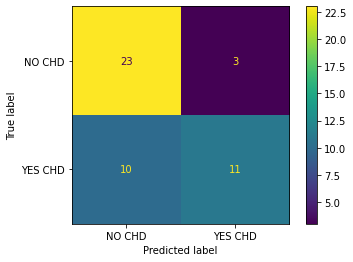

In [ ]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

X=dataset[['sbp','famhist','tobacco','ldl','adiposity','typea','obesity','alcohol','age']]
y=dataset['chd'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

print('X_train',len(X_train))
print('X_test', len(X_test))
print('y_train', len(y_train))
print('y_test',len(y_test))

rf_model = RandomForestClassifier(n_estimators=100, max_features=3)

kfold = StratifiedKFold(n_splits = 10, random_state = 1, shuffle=True)
cv_results = cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='accuracy',error_score='raise')
print('%s: %f (%f)' % ("CART", cv_results.mean(), cv_results.std()))

rf_model.fit(X_train, y_train)

predictions = rf_model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test,predictions[:,1])

# AUC ROC Curve
auc_cart = auc(fpr,tpr)
plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr,tpr,linestyle='-', label='AUC = %0.3f' % auc_cart)
plt.xlabel('False Positive Rate')
plt.title("AUC ROC Curve")
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Confusion Matrix

plot_confusion_matrix(rf_model, X_test, y_test, display_labels=["NO CHD", "YES CHD"])

# Accuracy and Precision

print("Accuracy", 34/47)
print("PrecisionNEG", 23/26)
print("PrecisionPOS", 11/21)










# Questão 5

Text(0.5, 1.0, 'Features mais relevantes para predição')

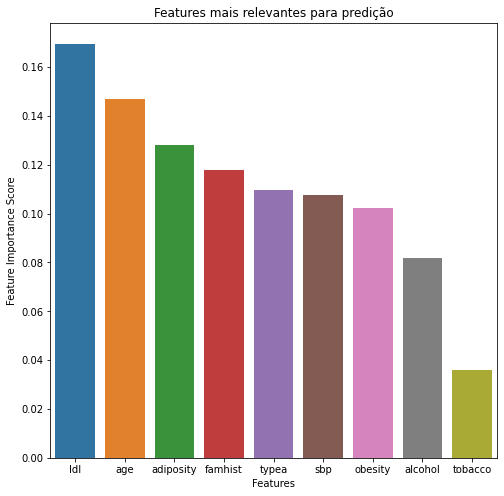

In [39]:
clf = RandomForestClassifier(n_estimators=100)

clf.fit(X_train,y_train)

feature_names = dataset.drop(['id', 'chd'], axis=1).keys()


feature_imp = pd.Series(clf.feature_importances_, index=feature_names).sort_values(ascending=False)
feature_imp

plt.figure(figsize=(8,8))
sns.barplot(x=feature_imp.index, y=feature_imp)
plt.xlabel('Features')
plt.ylabel('Feature Importance Score')
plt.title("Features mais relevantes para predição")




# Templates

In [ ]:


def fitting(X, y, criterion, splitter, mdepth, clweight):

    # Create training and testing samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


    # Fit the model
    model = tree.DecisionTreeClassifier(criterion=criterion, 
                                        splitter=splitter, 
                                        max_depth=mdepth,
                                        class_weight=clweight,
                                  
                                        random_state=0, 
                                  )
    
    # Cross validation test
    kfold = StratifiedKFold(n_splits=10, random_state=0, shuffle
    =True)

    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    print('Results of training CART')
    print('%s: %f (%f)' % ('CART', cv_results.mean(), cv_results.std()))

                                  
    clf = model.fit(X_train, y_train)

    # Predict class labels on training data
    pred_labels_tr = model.predict(X_train)
    # Predict class labels on a test data
    pred_labels_te = model.predict(X_test)

    # Tree summary and model evaluation metrics
    print('*************** Tree Summary ***************')
    print('Classes: ', clf.classes_)
    print('Tree Depth: ', clf.tree_.max_depth)
    print('No. of leaves: ', clf.tree_.n_leaves)
    print('No. of features: ', clf.n_features_in_)
    print('--------------------------------------------------------')
    print("")
    

    print('*************** Evaluation on Training Data ***************')
    score_tr = model.score(X_train, y_train)
    print('Accuracy Score: ', score_tr)
    # Look at classification report to evaluate the model
    print(classification_report(y_train, pred_labels_tr))
    print('--------------------------------------------------------')


    print('*************** Evaluation on Test Data ***************')
    score_te = model.score(X_test, y_test)
    print('Accuracy Score: ', score_te)
    # Look at classification report to evaluate the model
    print(classification_report(y_test, pred_labels_te))
    print('--------------------------------------------------------')
    print("")
    
  
    
    # Plotting Tree
    dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X.columns, 
                                class_names=[str(list(clf.classes_)[0]), str(list(clf.classes_)[1])],
                                filled=True, 
                                rounded=True, 
                                #rotate=True,
                               ) 
    graph = graphviz.Source(dot_data)
    
    # Return relevant data for chart plotting
    return X_train, X_test, y_train, y_test, clf, graph
                                 
